In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('new_train2.csv')
test = pd.read_csv('new_test.csv')

df['label'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
del df['y']

X = df.drop('label', axis=1)
y = df['label']

In [3]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical_features = ['age', 'duration', 'campaign']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [4]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [6]:
def train_model(X, y, model, dense_transform=False):
    """
    Train the model and return the trained pipeline.
    """
    steps = [('preprocessor', preprocessor), ('classifier', model)]
    if dense_transform:
        steps.insert(-1, ('to_dense', DenseTransformer()))
    
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X, y)
    
    return pipeline

In [7]:
def evaluate_model(X, y, trained_pipeline, model_name):
    """
    Evaluate the model using ROC AUC score and plot the ROC curve.
    """
    cv = StratifiedKFold(n_splits=5)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train, test in cv.split(X, y):
        probas_ = trained_pipeline.predict_proba(X.iloc[test])
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, label=f'{model_name} ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()


In [8]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# logestic regression
# k nearest neighbors
# naive bayes
# decision tree
models = [
    (LogisticRegression(solver='liblinear', max_iter=1000), "Logistic Regression", False),
    (KNeighborsClassifier(), "KNN", True),
    (GaussianNB(), "Naive Bayes", True),
    (DecisionTreeClassifier(), "Decision Tree", False)
]

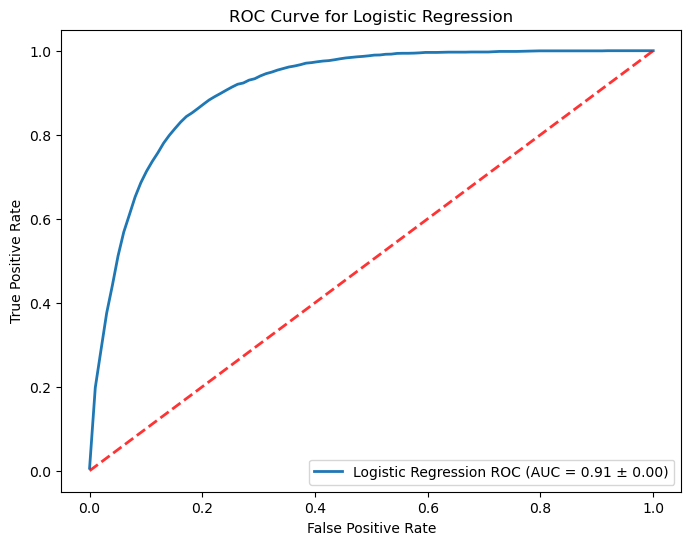

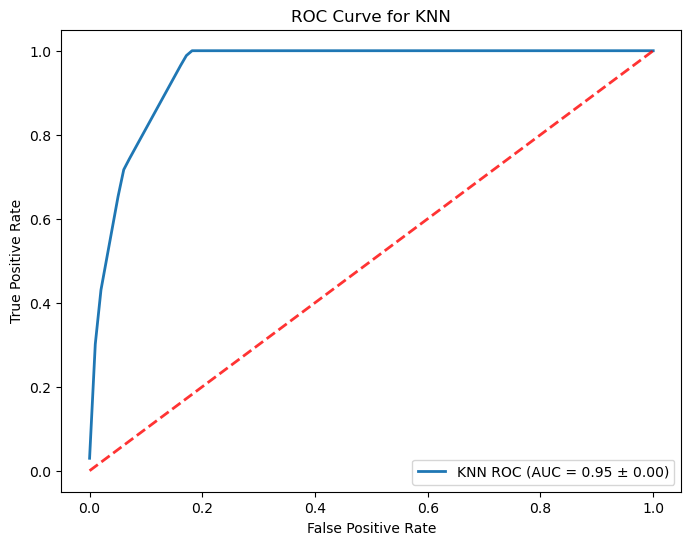

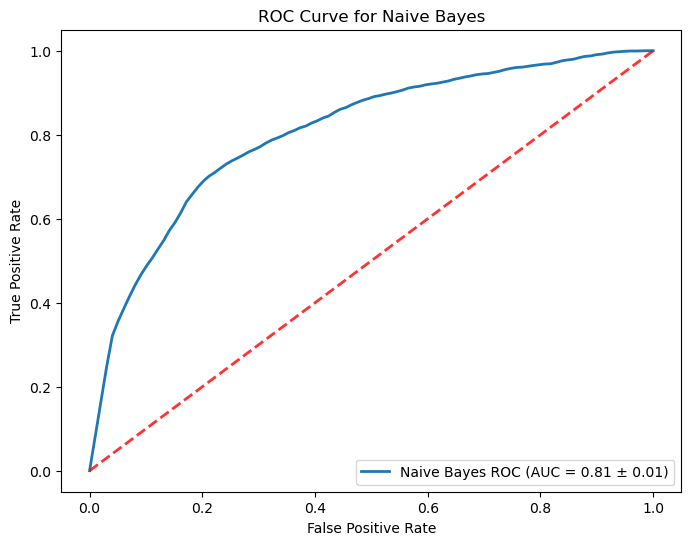

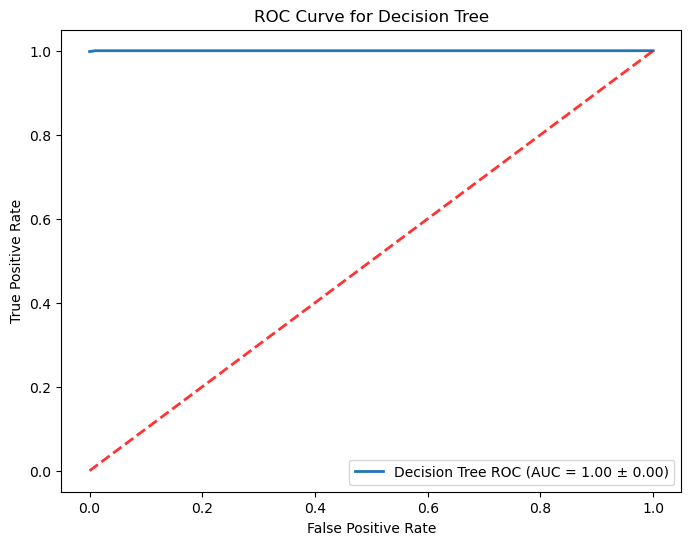

In [10]:
for model, name, dense_transform in models:
    trained_pipeline = train_model(X_train, y_train, model, dense_transform)
    evaluate_model(X_train, y_train, trained_pipeline, name)